# Day 16 - Tutorial 02 - Pyrolysis of hydrocarbons

In the previous tutorial we validated the conversion from [Cantera](https://cantera.org/) to OpenFOAM of a chemical kinetics mechanism established in this [thesis](http://docnum.univ-lorraine.fr/public/DDOC_T_2017_0158_DAL_MAZ_SILVA.pdf). Here we make use of that mechanism to simulate the behavior of acetylene pyrolysis under low pressure conditions relevant to vacuum carburizing of steel. More specifically we will reproduce conditions provided in table 5.9 of the document and simulations will be carried out with the skeletal DRG mechanism only.

We import everything on top as usual, usage of packages being discussed as they come.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from textwrap import dedent
from scipy.optimize import curve_fit
from skimage.io import imsave
from jinja2 import Template
import shutil
import warnings
import numpy as np
import pandas as pd
import pyvista as pv
import cantera as ct
import matplotlib.pyplot as plt
import cfdtoolbox.foam as fu
import cfdtoolbox.prep as prep

ct.suppress_thermo_warnings()
pv.set_jupyter_backend("static")
pv.start_xvfb()

Before starting the case construction we define external materials/names for common use throughout the notebook. That means the *name* of this case under directory `case/` so that results are not tracked by `git`, the mesh file, and chemical kinetics mechanism. Here both OpenFOAM and Cantera formats are required because post-processing will be done with the latter. We also have a file with actual measurements of wall temperature, which will be fit to a functional format and implemented as a coded boundary condition.

**TODO:** remplace Cantera XML files by newer format YAML.

In [3]:
case = "cases/foam-day-16-tutorial-02-pyrolysis"

case_mesh_of = "meshes/mesh_wedge_phd.msh"
case_ther_of = "kinetics/OF-hydrocarbon-dalmazsi-2017-ther.foam"
case_mech_of = "kinetics/OF-hydrocarbon-dalmazsi-2017-mech.foam"
case_mech_ct = "kinetics/CT-hydrocarbon-dalmazsi-2017-mech.xml"

case_wall_tm = "data/foam-day-16-tutorial-02-pyrolisys-wall-temperature.csv"

## Reactor geometry and temperature profile

A sketch of the chemical reactor is provided below. Gas inlet is made by the left side in the diameter of 28 mm and flows at about room temperature until reaching the heated chamber at 20 cm. Pressure is measured at outlet and this will be important later for proper setup of boundary conditions.



<center><img src="media/foam-day-16-tutorial-02-pyrolysis-reactor.png"/></center>

To fit a function of wall temperature profile the following table is used. Notice here that measurements do not cover the full 80 cm of the reactor, but are in fact centered in the hot zone across a length of 52 cm. The first 3 rows we manually added (not actual measurements, so heated chamber starts actually at 12 cm) to provide a physically suitable shape for fitting the curve. Same was done on last row because measurement on chamber exit was highly unreliable because of thermocouple placement and contact with the wall.

In [4]:
data = pd.read_csv(case_wall_tm)
data

,x,773,873,973,1023,1073,1123,1173,1223,1273
0,0.00,298,298.0,298,298,298.0,298,298.0,298.0,298.0
1,0.05,299,299.0,299,299,299.0,299,299.0,299.0,299.0
2,0.10,300,300.0,300,300,300.0,300,300.0,300.0,300.0
3,0.12,400,503.0,653,689,726.0,755,783.0,793.0,803.0
4,0.15,650,757.0,873,896,919.0,959,1000.0,1048.0,1095.0
5,0.20,750,834.0,918,965,1013.0,1057,1101.0,1151.0,1200.0
6,0.25,762,850.0,949,1001,1052.0,1098,1143.0,1189.0,1235.0
7,0.30,763,869.0,971,1018,1064.0,1110,1156.0,1205.0,1253.0
8,0.35,763,859.0,954,1001,1047.5,1095,1142.5,1188.5,1233.5
9,0.40,763,849.0,937,984,1031.0,1080,1129.0,1172.0,1214.0


As we observe on row 7, temperature in the middle of the reactor heated zone does not reach the set-point value. Below we verify that actually abot 99% of the value is actually reached and this is an important factor for a proper kinetics simulation given the exponential role of activation energies.

In [5]:
T_pv = data.iloc[7, 1:].to_numpy()
T_sp = data.columns[1:].astype(float).to_numpy()
scale = (T_pv / T_sp)
scale

array([0.98706339, 0.9954181 , 0.9979445 , 0.99511241, 0.9916123 ,
       0.98842386, 0.98550725, 0.98528209, 0.98428908])

Given the increasing-plateau-decreasing shape of the profile, a composition of sigmoid functions is proposed as a model for the data. The function is evaluated in terms of temperature and has a physical parameter `T_sp` for set-point temperature. Other parameters are fitted to match the profile. Parameters `a1`/`a2` provide the inflexion points and `m1`/`m2` the slopes of uphill/downhill profiles.

In [6]:
def temperature_profile(x, T_sp, a1, a2, m1, m2):
    """ Wall temperature profile function. """
    st_trm = (T_sp - 301.0) * (1.0 - np.exp(-(x / a1) ** m1))
    nd_trm = (T_sp - 400.0) * (1.0 - np.exp(-(x / a2) ** m2))
    return 301.0 + st_trm - nd_trm

Next we make use of `scipy.optimize.curve_fit` to find the unknown parameters and visualize the results.

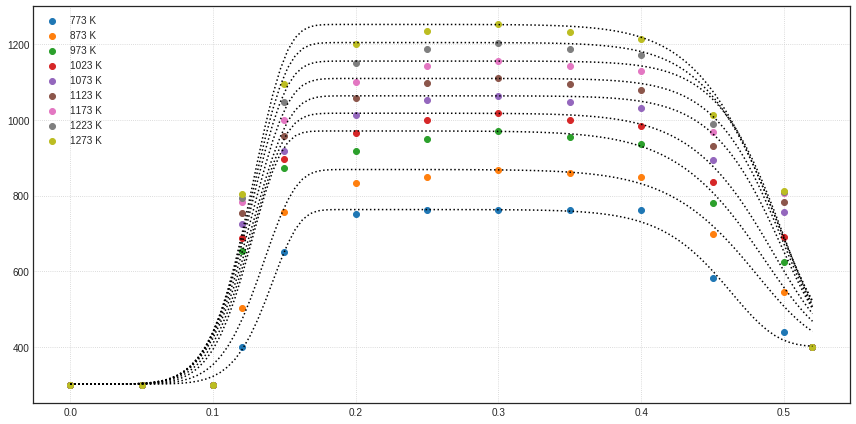

In [7]:
params = []

plt.style.use("seaborn-white")
plt.close("all")
plt.figure(figsize=(12, 6))

X = np.linspace(data["x"].min(), data["x"].max(), 100)

for k, T_sp in enumerate(data.columns[1:]):
    arrX = data["x"].to_numpy()
    arrT = data[T_sp].to_numpy()

    def wrap(x, a1, a2, m1, m2):
        T_pv = float(T_sp) * scale[k]
        return temperature_profile(x, T_pv, a1, a2, m1, m2)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        guess = 0.1, 0.6, 2.0, 2.0
        popt, pcov = curve_fit(wrap, arrX, arrT, guess, maxfev=10_000)
    
    params.append([float(T_sp), scale[k], *popt])
    plt.scatter(arrX, arrT, label=f"{T_sp} K")
    plt.plot(X, wrap(X, *popt), "k:", label="_none_")
    
plt.grid(linestyle=":")
plt.legend(loc=2)
plt.tight_layout()

In [8]:
params_df = pd.DataFrame(params)
params_df.columns = ["T", "scale", "a1", "a2", "m1", "m2"]
params_df

,T,scale,a1,a2,m1,m2
0,773.0,0.987063,0.143839,0.465366,8.498838,15.589542
1,873.0,0.995418,0.138845,0.485018,7.161445,12.858167
2,973.0,0.997945,0.130311,0.490096,7.219046,12.825122
3,1023.0,0.995112,0.131512,0.495795,6.623234,14.073047
4,1073.0,0.991612,0.132188,0.500856,6.254104,16.953023
5,1123.0,0.988424,0.131778,0.501189,6.313607,17.562174
6,1173.0,0.985507,0.131360,0.501379,6.396871,18.019475
7,1223.0,0.985282,0.131623,0.498994,6.550948,15.856002
8,1273.0,0.984289,0.131839,0.496996,6.695226,14.754026


We translate the fitted function in C++ and create a `codedFixedValue` boundary condition for enforcing the profile.

In [9]:
wall_temperature_bc = """\
        type  codedFixedValue;
            value $internalField;
            name  wall_temperature_bc;

            code
            #{{
                double T_sp = {scale:.6f} * {T:.2f};
                double a1 = {a1:.12f}, m1 = {m1:.12f};
                double a2 = {a2:.12f}, m2 = {m2:.12f};

                vector axisX = vector(1, 0, 0);
                scalarField x = (patch().Cf() & axisX);

                scalarField u = Foam::pow(x / a1, m1);
                scalarField d = Foam::pow(x / a2, m2);

                scalarField Tu = (T_sp - 301.0) * (1 - Foam::exp(-u));
                scalarField Td = (T_sp - 400.0) * (1 - Foam::exp(-d));

                scalarField Tval = 301 + Tu - Td;
                operator==(Tval);
            #}};\
""".format(**params_df.iloc[6].to_dict())

print(wall_temperature_bc)

        type  codedFixedValue;
            value $internalField;
            name  wall_temperature_bc;

            code
            #{
                double T_sp = 0.985507 * 1173.00;
                double a1 = 0.131360276011, m1 = 6.396870587401;
                double a2 = 0.501378719714, m2 = 18.019474815463;

                vector axisX = vector(1, 0, 0);
                scalarField x = (patch().Cf() & axisX);

                scalarField u = Foam::pow(x / a1, m1);
                scalarField d = Foam::pow(x / a2, m2);

                scalarField Tu = (T_sp - 301.0) * (1 - Foam::exp(-u));
                scalarField Td = (T_sp - 400.0) * (1 - Foam::exp(-d));

                scalarField Tval = 301 + Tu - Td;
                operator==(Tval);
            #};


A parametric mesh was conceived with `gmsh` scripting. Next we execute the system command to generate `msh2` format that can be read by `gmshToFoam` later.

In [10]:
!cd meshes && gmsh mesh_wedge_phd.geo -3 -format msh2 > gmsh.log

We visualize the mesh applying a 10-fold magnification over y axis to check the grading.

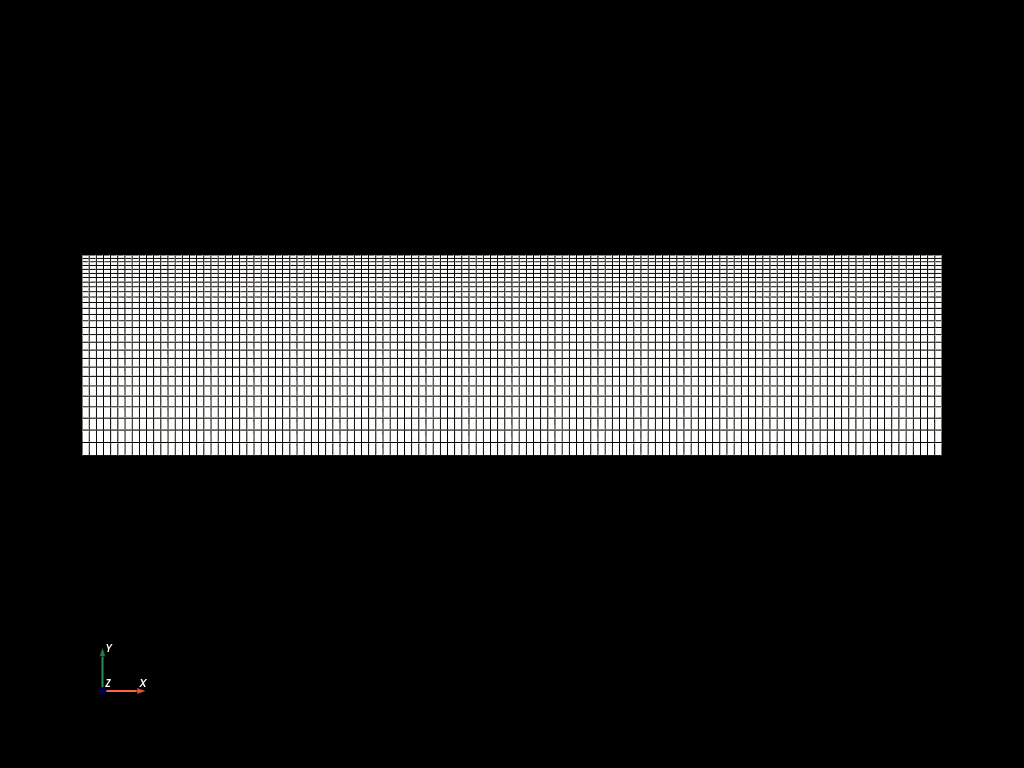

In [11]:
cpos = ((0.3, 0.005, 1.0),
        (0.3, 0.005, 0.0),
        (0.0, 0.000, 0.0))

mtm = np.diag([1, 10, 1, 1])

fu.mesh.plot_mesh(case_mesh_of, cpos=cpos, mtm=mtm)

## Case fields template

To build the case boundary conditions we need to generate a template for filling with the parameters for each variable in the problem. Module `cfdtoolbox.foam.mesh` provides a functionality for parsing MSH2 format exported from `gmsh` and retrieve field names. Notice that since we add volume fields we might wish to filter the list returned by this function. In the following we need to suppress `inner` from the list (check `.geo` file for details).

In [12]:
boundaries = fu.mesh.get_gmsh2_patches_names(case_mesh_of)
boundaries

['front', 'back', 'wall', 'inlet', 'outlet', 'inner']

Below we create the template compatible with the patches of this case.

In [13]:
boundaries = boundaries[:-1]
boundaryField = fu.boundary_fields_template(boundaries)
print(dedent(boundaryField.render()))

dimensions      ;

internalField   uniform ;

boundaryField
{

    front
    {

    }

    back
    {

    }

    wall
    {

    }

    inlet
    {

    }

    outlet
    {

    }

}



## Initial conditions

Here we will simulate case number 6 of table 5.9 of the reference thesis. 

As a first step we provide temperature and pressure.

Inlet mean gas speed is computed from flow rate and reactor cross-section.

In [14]:
T = 1173.15
P = 5000.0

T_room = 301.0
A = np.pi * 0.014 ** 2
U = prep.sccm_to_meter_per_second(222.0, T_room, P, A)

Next we compute the reference initial conditions in required units. 

Since acetylene is stored in liquid acetone, pollution of the gas is expected are discussed by [Noringa, 2009].

Composition is converted to mass fractions as required by `reactingFoam`.

In [15]:
C = 0.36
X = {"N2":       0.64,
     "C2H2":     0.980 * C,
     "CH3COCH3": 0.018 * C,
     "CH4":      0.002 * C}

gas = ct.Solution(case_mech_ct, "gas")
gas.TPX = T, P, X

Y = gas.mass_fraction_dict()
Y["total"] = sum(Y.values())
pd.DataFrame.from_dict([Y])

,C2H2,CH3COCH3,CH4,N2,total
0,0.334007,0.013684,0.00042,0.651889,1.0


Since the wedge boundary conditions is shared by all variables we create a dictionary for storing it.

In [16]:
wedges = {"front": fu.BC_WEDGE, "back": fu.BC_WEDGE}

Another recurring template is the one used for species, so we prepare here its general view.

Composition is fixed at inlet and an `inletOutlet` is applied to outlet.

In [17]:
body_species = {
    "dimensions": fu.DIMENSIONS["0"],
    "uniform":    "{{ inlet }}",
    "inlet":      fu.BC_FIXED_VALUE.format(value="{{ inlet }}"),
    "outlet":     fu.BC_INLET_OUTLET.format(value="{{ inlet }}", inletValue="{{ inlet }}"),
    "wall":       fu.BC_ZERO_GRADIENT,
    **wedges
}

body_species = Template(boundaryField.render(**body_species))

In [18]:
body_p = {
    "dimensions": fu.DIMENSIONS["p"],
    "uniform":    P,
    "inlet":      fu.BC_ZERO_GRADIENT,
    "outlet":     fu.BC_TOTAL_PRESSURE.format(p0="$internalField"),
    "wall":       fu.BC_ZERO_GRADIENT,
    **wedges
}

body_U = {
    "dimensions": fu.DIMENSIONS["U"],
    "uniform":    f"({U} 0 0)",
    "inlet":      fu.BC_FIXED_VALUE.format(value=f"({U} 0 0)"),
    "outlet":     fu.BC_PRESSURE_INLET_OUTLET_VELOCITY.format(value="$internalField"),
    "wall":       fu.BC_NOSLIP,
    **wedges
}

body_T = {
    "dimensions": fu.DIMENSIONS["T"],
    "uniform":    T_room,
    "inlet":      fu.BC_FIXED_VALUE.format(value=T_room),
    "outlet":     fu.BC_INLET_OUTLET.format(value=T_room, inletValue=T_room),
    "wall":       wall_temperature_bc,
    **wedges
}

body_p        = dedent(boundaryField.render(**body_p))
body_U        = dedent(boundaryField.render(**body_U))
body_T        = dedent(boundaryField.render(**body_T))
body_C2H2     = dedent(body_species.render(inlet=Y["C2H2"]))
body_CH3COCH3 = dedent(body_species.render(inlet=Y["CH3COCH3"]))
body_CH4      = dedent(body_species.render(inlet=Y["CH4"]))
body_N2       = dedent(body_species.render(inlet=Y["N2"]))
body_Ydefault = dedent(body_species.render(inlet=0.0))

In [19]:
# print(body_p)

In [20]:
# print(body_U)

In [21]:
# print(body_T)

In [22]:
# print(body_C2H2)

In [23]:
# print(body_CH3COCH3)

In [24]:
# print(body_CH4)

In [25]:
# print(body_N2)

In [26]:
# print(body_Ydefault)

## Constant

Next we constitute the dictionaries for `constant/` directory.

The first one is `chemicalProperties` for which the most important point is the choice of `seulex` as stiff ODE solver.

In [27]:
body_chemistryProperties = """\
chemistryType
{
    chemistrySolver  ode;
    chemistryThermo  psi;
    TDAC             off;
}

chemistry            on;

importantSpecies
{
    C2H2;
    C4H2;
    C4H4;
    CH4;
    H2;
}

initialChemicalTimeStep 1.0e-07;

odeCoeffs
{
    solver          seulex;
    absTol          1.0e-12;
    relTol          1.0e-03;
}
"""

Given the low speeds and low pressure of the problem a laminar model is created.

In `combustionProperties` we set `active` to `true`, otherwise chemistry is not solved. I find this particularly intriguing because in `chemistryProperties` we have already a flag `chemistry` to turn it on/off. Need to clarify why both are required.

In [28]:
body_turbulenceProperties = """\
simulationType  laminar;
"""

body_combustionProperties = """\
combustionModel laminar;

active          true;
"""

Finally we set gravity on vertical axis and the `thermophysicalProperties` file, which points to the mechanism and thermodynamic properties files.

Transport properties are composition dependent through a Sutherland model and thermodynamic properties are provided by JANAF polynomials.

In [29]:
body_g = fu.gravity_file("y")

body_thermophysicalProperties = """\
thermoType
{
    type            hePsiThermo;
    mixture         reactingMixture;
    transport       sutherland;
    thermo          janaf;
    energy          sensibleEnthalpy;
    equationOfState perfectGas;
    specie          specie;
}

inertSpecie N2;

chemistryReader         foamChemistryReader;
foamChemistryFile       "<constant>/reactions";
foamChemistryThermoFile "<constant>/thermo";
"""

## System

In `controlDict` we set a small time-step required for properly integrating chemistry. Alternativelly one might set `deltaT` to unit and advance the problem with pseudo time-stepping to reach steady state. Time step is adjusted internally to ensure a maximum Courant number of 0.25.

In [30]:
body_controlDict = """\
application       reactingFoam;

startFrom         latestTime;

startTime         0;

stopAt            endTime;

endTime           100.0;

deltaT            1.0e-05;

writeControl      runTime;

writeInterval     1;

purgeWrite        0;

writeFormat       ascii;

writePrecision    6;

writeCompression  off;

timeFormat        fixed;

timePrecision     5;

runTimeModifiable true;

maxCo             0.25;

adjustTimeStep    yes;
"""

Regarding `fvSchemes` we use an implicit time-stepping with `backward` for improved stability and limited divergent schemes in most cases.

In [31]:
body_fvSchemes = """\
ddtSchemes
{
    default          backward;
}

gradSchemes
{
    default          Gauss linear;
}

divSchemes
{
    default          none;
    div(phid,p)      Gauss limitedLinear   1;
    div(phi,U)       Gauss limitedLinearV  1;
    div(phi,K)       Gauss limitedLinear   1;
    div(phi,Yi_h)    Gauss limitedLinear01 1;
    div(((rho*nuEff)*dev2(T(grad(U))))) Gauss linear;
}

laplacianSchemes
{
    default          Gauss linear orthogonal;
}

interpolationSchemes
{
    default          linear;
}

snGradSchemes
{
    default          orthogonal;
}
"""

For `fvSolution` we tighten convergence criteria for species and energy.

Configuration of PIMPLE remains mostly standard.

In [32]:
body_fvSolution = """\
solvers
{
    "rho.*"
    {
        solver          diagonal;
    }

    p
    {
        solver          PCG;
        preconditioner  DIC;
        tolerance       1.0e-06;
        relTol          0.01;
    }

    pFinal
    {
        $p;
        relTol          0;
    }

    U
    {
        solver          PBiCGStab;
        preconditioner  DILU;
        tolerance       1.0e-06;
        relTol          0.1;
    }

    UFinal
    {
        solver          PBiCGStab;
        preconditioner  DILU;
        tolerance       1.0e-06;
        relTol          0;
    }

    h
    {
        solver          PBiCGStab;
        preconditioner  DILU;
        tolerance       1.0e-07;
        relTol          0.1;
    }

    hFinal
    {
        solver          PBiCGStab;
        preconditioner  DILU;
        tolerance       1.0e-09;
        relTol          0;
    }
    
    Yi
    {
        solver          PBiCGStab;
        preconditioner  DILU;
        tolerance       1.0e-12;
        relTol          0.01;
    }
}

PIMPLE
{
    momentumPredictor        no;
    nOuterCorrectors         1;
    nCorrectors              2;
    nNonOrthogonalCorrectors 0;

    maxDeltaT                1.0e-03;
    maxCo                    0.25;
    alphaTemp                0.05;
    alphaY                   0.05;
    Yref
    {
        N2                   0.6;
        H2                   0.1;
        C2H2                 0.3;
    }
    rDeltaTSmoothingCoeff    0.025;
    rDeltaTDampingCoeff      1;
}

relaxationFactors
{
    fields
    {
        p                    0.3;
    }
    equations
    {
        U                    0.7;
        ".*"                 0.4;
    }
}
"""

It is unrealistic to simulate chemical kinetics without parallelism.

Here we split the system in 4 processors along the flow direction, leading to 3 interfaces.

In [33]:
body_decomposeParDict = """\
numberOfSubdomains  4;

method              hierarchical;

coeffs
{
    n               (4 1 1);
}
"""

## Generate case

In [34]:
source = "/usr/lib/openfoam/openfoam2106/etc/bashrc"

fu.make_file(case, "0.00000",  "p",                        body_p)
fu.make_file(case, "0.00000",  "U",                        body_U)
fu.make_file(case, "0.00000",  "T",                        body_T)
fu.make_file(case, "0.00000",  "C2H2",                     body_C2H2,     class_type="scalar")
fu.make_file(case, "0.00000",  "CH3COCH3",                 body_CH3COCH3, class_type="scalar")
fu.make_file(case, "0.00000",  "CH4",                      body_CH4,      class_type="scalar")
fu.make_file(case, "0.00000",  "N2",                       body_N2,       class_type="scalar")
fu.make_file(case, "0.00000",  "Ydefault",                 body_Ydefault, class_type="scalar")
fu.make_file(case, "constant", "chemistryProperties",      body_chemistryProperties)
fu.make_file(case, "constant", "combustionProperties",     body_combustionProperties)
fu.make_file(case, "constant", "g",                        body_g)
fu.make_file(case, "constant", "thermophysicalProperties", body_thermophysicalProperties)
fu.make_file(case, "constant", "turbulenceProperties",     body_turbulenceProperties)
fu.make_file(case, "system",   "controlDict",              body_controlDict)
fu.make_file(case, "system",   "decomposeParDict",         body_decomposeParDict)
fu.make_file(case, "system",   "fvSchemes",                body_fvSchemes)
fu.make_file(case, "system",   "fvSolution",               body_fvSolution)
    
_ = shutil.copy(case_mesh_of, f"{case}/mesh.msh")
_ = shutil.copy(case_mech_of, f"{case}/constant/reactions")
_ = shutil.copy(case_ther_of, f"{case}/constant/thermo")

We still need to convert mesh to OpenFOAM format with `gmshToFoam`.

In [35]:
fu.run_cmd(case, "log.gmshToFoam",
           f". {source} && gmshToFoam mesh.msh")

Running from cases/foam-day-16-tutorial-02-pyrolysis


It is good practice to check mesh quality and keep a report of it with `checkMesh`.

In [36]:
fu.run_cmd(case, "log.checkMesh",
           f". {source} && checkMesh")

Running from cases/foam-day-16-tutorial-02-pyrolysis


File `constant/polyMesh/boundary` has to be edited to declare the wedges.

This can be done with `pyFoamChangeBoundaryType.py` from `pyfoam` package.

In [37]:
fu.run_cmd(case, "log.pyFoamChangeBoundaryTypeFront",
           f". {source} && pyFoamChangeBoundaryType.py . front wedge")
fu.run_cmd(case, "log.pyFoamChangeBoundaryTypeBack",
           f". {source} && pyFoamChangeBoundaryType.py . back  wedge")

Running from cases/foam-day-16-tutorial-02-pyrolysis
Running from cases/foam-day-16-tutorial-02-pyrolysis


Decomposition of domain over multiple processors is reached with `decomposePar`.

In [38]:
fu.run_cmd(case, "log.decomposePar",
           f". {source} && decomposePar")

Running from cases/foam-day-16-tutorial-02-pyrolysis


Finally the case is ready to be launched though `mpirun` or alternatively with `foamJob`.

You can generate XY data for plotting convergence by running `foamLog log.reactingFoam`.

In [39]:
fu.run_cmd(case, "log.reactingFoam",
           f". {source} && mpirun -np 4 reactingFoam -parallel &")

Running from cases/foam-day-16-tutorial-02-pyrolysis


To provide full system visualization we need to run `reconstructPar`.

Option `-newTimes` is provided to process only those steps not already converted.

Since post-processing is carried out with `pyvista` we convert all files to `VTK` format with `foamToVTK`.

Notice that option `-newTimes` is not available in this case and we convert only the latest.

In [139]:
fu.run_cmd(case, "log.reconstructPar",
           f". {source} && reconstructPar -newTimes")

fu.run_cmd(case, "log.foamToVTK",
           f". {source} && foamToVTK -latestTime")

!ls -1d cases/foam-day-16-tutorial-02-pyrolysis/VTK/*/

Running from cases/foam-day-16-tutorial-02-pyrolysis
Running from cases/foam-day-16-tutorial-02-pyrolysis
cases/foam-day-16-tutorial-02-pyrolysis/VTK/foam-day-16-tutorial-02-pyrolysis_1279/
cases/foam-day-16-tutorial-02-pyrolysis/VTK/foam-day-16-tutorial-02-pyrolysis_1458/
cases/foam-day-16-tutorial-02-pyrolysis/VTK/foam-day-16-tutorial-02-pyrolysis_1574/
cases/foam-day-16-tutorial-02-pyrolysis/VTK/foam-day-16-tutorial-02-pyrolysis_1756/
cases/foam-day-16-tutorial-02-pyrolysis/VTK/foam-day-16-tutorial-02-pyrolysis_2008/
cases/foam-day-16-tutorial-02-pyrolysis/VTK/foam-day-16-tutorial-02-pyrolysis_2504/
cases/foam-day-16-tutorial-02-pyrolysis/VTK/foam-day-16-tutorial-02-pyrolysis_3410/
cases/foam-day-16-tutorial-02-pyrolysis/VTK/foam-day-16-tutorial-02-pyrolysis_6617/
cases/foam-day-16-tutorial-02-pyrolysis/VTK/foam-day-16-tutorial-02-pyrolysis_7848/
cases/foam-day-16-tutorial-02-pyrolysis/VTK/foam-day-16-tutorial-02-pyrolysis_874/
cases/foam-day-16-tutorial-02-pyrolysis/VTK/foam-day-16

## Post-processing

Some options that are constant across views are declared.

This regards camera placement, color bars, and domain scaling.

In [142]:
cpos = ((0.3, 0.006, 1.0),
        (0.3, 0.006, 0.0),
        (0.0, 0.0, 0.0))

opts = dict(
    cmap="jet",
    pbr=False,
    scalar_bar_args=dict(
        height=0.1,
        width=0.9, 
        vertical=False, 
        position_x=0.05,
        position_y=0.12,
        color="w",
        n_colors=12,
        n_labels=13,
        fmt="%.3f"
    )
)

lopts = dict(color="k", line_width=1)

mtm = np.diag([1, 20, 1, 1])

Chemical composition units output by `reactingFoam` are not convenient for analysis.

Below we make use of Cantera to perform conversion of compositions into mole fractions.

In [140]:
mesh = pv.read(f"{case}/VTK/foam-day-16-tutorial-02-pyrolysis_9489/internal.vtu")

# With T straight it doesn't work (maybe transposal?)!
mesh.point_data["Temperature [K]"] = np.array(mesh.point_data["T"])
mesh.point_data["Velocity-X [m/s]"] = np.array(mesh.point_data["U"][:, 0])

gas = ct.Solution(case_mech_ct)
mass_frac_df = pd.DataFrame({species: mesh.point_data[species] 
                             for species in gas.species_names})
mass_frac_df["T"] = mesh.point_data["T"]
mass_frac_df["P"] = mesh.point_data["p"]

mole_frac_df = []
for k, row in mass_frac_df.iterrows():
    gas.TPY = row["T"], row["P"], row[gas.species_names]
    mole_frac_df.append(gas.mole_fraction_dict())
    
mole_frac_df = pd.DataFrame(mole_frac_df)

for species in mole_frac_df.columns:
    mesh.point_data[f"X({species})"] = mole_frac_df[species].to_numpy()

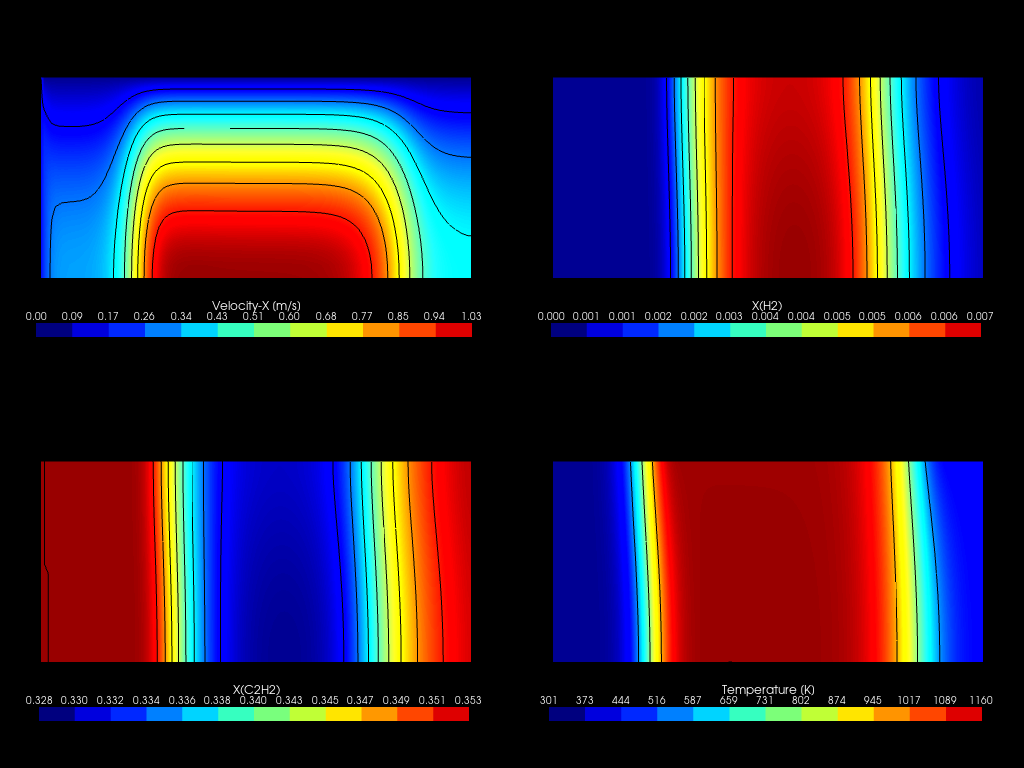

In [141]:
midplane = mesh.slice(normal=[0, 0, 1])

p = pv.Plotter(shape="2|2", notebook=True)
p.set_background(color="k")

p.subplot(0)
opts["scalar_bar_args"]["fmt"] = "%.2f"
p.add_mesh(midplane.copy(), **opts, scalars="Velocity-X [m/s]")
p.add_mesh(midplane.contour(10, scalars="Velocity-X [m/s]"), **lopts)

p.subplot(1)
opts["scalar_bar_args"]["fmt"] = "%.3f"
p.add_mesh(midplane.copy(), **opts, scalars="X(C2H2)")
p.add_mesh(midplane.contour(10, scalars="X(C2H2)"), **lopts)

p.subplot(2)
opts["scalar_bar_args"]["fmt"] = "%.3f"
p.add_mesh(midplane.copy(), **opts, scalars="X(H2)")
p.add_mesh(midplane.contour(10, scalars="X(H2)"), **lopts)

p.subplot(3)
opts["scalar_bar_args"]["fmt"] = "%.0f"
p.add_mesh(midplane.copy(), **opts, scalars="Temperature [K]")
p.add_mesh(midplane.contour(5, scalars="Temperature [K]"), **lopts)

p.link_views()
p.camera.model_transform_matrix = mtm
p.show(cpos=cpos)

imsave("media/foam-day-16-tutorial-02-pyrolysis.png", p.image)

This notebook illustrated an end-to-end project of chemically reacting flows.

We have been able to reproduce simulations performed with a plug-flow reactor model in a full 3-D (axisymmetric) case.

Hope you have enjoyed, see you next time!